In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, join
import numpy as np
import os
import glob
from desisim.quickcat import quickcat
import fitsio
%matplotlib inline

In [2]:
program = 'dark'
main_path = "/global/cscratch1/sd/forero/elgsplit/"

In [11]:
truth = Table.read(os.path.join(main_path, 'targets', program, 'truth.fits'))
mtl = Table.read(os.path.join(main_path, 'zcat', program, '0', 'mtl.fits'))
zcat = Table.read(os.path.join(main_path, 'zcat', program, '16','zcat.fits'))

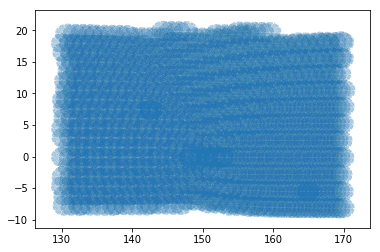

In [12]:
inz = np.in1d(mtl['TARGETID'], zcat['TARGETID'])
plt.scatter(mtl['RA'][inz], mtl['DEC'][inz], s=1E-4)

In [13]:
expfile = os.path.join(main_path, 'survey','exposures_dark_baseline_1m.fits')
explist = Table.read(expfile)

dark_tiles = list(set(explist['TILEID'][explist['PROGRAM']=='DARK']))
gray_tiles = list(set(explist['TILEID'][explist['PROGRAM']=='GRAY']))
print(len(dark_tiles))
print(len(gray_tiles))

637
158


In [14]:
tilefiles = glob.glob(main_path+"/zcat/dark/*/fiberassign/tile*.fits")

In [15]:
graytilefiles = []
for i in range(len(gray_tiles)):
    tilestring = '{:05d}'.format(gray_tiles[i])
    for tilefile in tilefiles:
        if tilefile.find(tilestring)>0:
            #print(tilefile, tilestring)
            graytilefiles.append(tilefile)
            
darktilefiles = []
for i in range(len(dark_tiles)):
    tilestring = '{:05d}'.format(dark_tiles[i])
    for tilefile in tilefiles:
        if tilefile.find(tilestring)>0:
            #print(tilefile, tilestring)
            darktilefiles.append(tilefile)

In [16]:
grayzcat = quickcat(graytilefiles, mtl, truth, perfect=True)

Wed Dec  6 16:24:27 2017 QC Reading 158 tiles
Wed Dec  6 16:24:30 2017 QC Trimming truth to just observed targets
Wed Dec  6 16:24:34 2017 QC Constructing new redshift catalog
Wed Dec  6 16:24:34 2017 QC Adding ZERR and ZWARN
Wed Dec  6 16:24:34 2017 QC Adding NUMOBS column
Wed Dec  6 16:24:40 2017 QC Merging previous zcat
Wed Dec  6 16:24:40 2017 QC done


In [17]:
darkzcat = quickcat(darktilefiles, mtl, truth, perfect=True)

Wed Dec  6 16:24:40 2017 QC Reading 639 tiles
Wed Dec  6 16:25:11 2017 QC Trimming truth to just observed targets
Wed Dec  6 16:25:17 2017 QC Constructing new redshift catalog
Wed Dec  6 16:25:17 2017 QC Adding ZERR and ZWARN
Wed Dec  6 16:25:17 2017 QC Adding NUMOBS column
Wed Dec  6 16:25:43 2017 QC Merging previous zcat
Wed Dec  6 16:25:43 2017 QC done


In [18]:
allzcat = quickcat(tilefiles, mtl, truth, perfect=True)

Wed Dec  6 16:25:43 2017 QC Reading 797 tiles
Wed Dec  6 16:26:01 2017 QC Trimming truth to just observed targets
Wed Dec  6 16:26:06 2017 QC Constructing new redshift catalog
Wed Dec  6 16:26:07 2017 QC Adding ZERR and ZWARN
Wed Dec  6 16:26:07 2017 QC Adding NUMOBS column
Wed Dec  6 16:26:41 2017 QC Merging previous zcat
Wed Dec  6 16:26:41 2017 QC done


In [19]:
def get_small_truth(truth_table, zcat_table, mtl_table):
    print('initializing small truth')
    small_truth = join(truth_table[['TARGETID','TEMPLATETYPE']], 
                       zcat_table['TARGETID', 'NUMOBS'], keys='TARGETID', join_type='outer')
    unobs  = small_truth['NUMOBS'].mask
    small_truth['NUMOBS'][unobs] = 0
    print('second join')
    small_truth = join(small_truth, mtl_table[['TARGETID', 'RA', 'DEC']], keys='TARGETID')
    return small_truth


In [20]:
def count_unused(tilefiles):
    unassigned = np.zeros(len(tilefiles))
    for i, filename in enumerate(tilefiles):
        fa = fitsio.read(filename, 'FIBER_ASSIGNMENTS', columns=['TARGETID',])
        unassigned[i] = np.count_nonzero(fa['TARGETID'] == -1)
    return unassigned

In [21]:
unused_all = count_unused(tilefiles)
unused_dark = count_unused(darktilefiles)
unused_gray = count_unused(graytilefiles)

In [22]:
small_truth_all = get_small_truth(truth, allzcat, mtl)
small_truth_dark = get_small_truth(truth, darkzcat, mtl)
small_truth_gray = get_small_truth(truth, grayzcat, mtl)
small_truth = get_small_truth(truth, zcat, mtl)

initializing small truth


second join


initializing small truth
second join
initializing small truth
second join
initializing small truth
second join


In [23]:
def print_eff(table_truth):
    name = {'DELG':'DELG      ', 'ELG':'ELG       ', 'QSO':'QSO       ', 'LRG':'LRG       ', 
           'SKY':'SKY       ', 'STAR':'STAR      '}
    in_square = (table_truth['RA']>130) &\
        (table_truth['RA']<169) &\
        (table_truth['DEC']<17) &\
        (table_truth['DEC']>-7)
    
    tmp_truth = table_truth[in_square]
    print("{}\t {}\t {}\t {}".format("Type", "In", "Out", "Out/In"))
    for k in ['DELG', 'ELG', 'LRG', 'QSO']:
        tmp_type = name[k]
        total = 1.0*np.count_nonzero( tmp_truth['TEMPLATETYPE'] == tmp_type)
        num_obs = 1.0*np.count_nonzero(tmp_truth['TEMPLATETYPE'][tmp_truth['NUMOBS']>0] == tmp_type)
        print("{}\t {:d}k\t {:d}k \t {:.2f}".format(k, int(total/1000), int(num_obs/1000), num_obs/total))

In [24]:
def print_unused(unused_fibers):
    total = 5000.0 * len(unused_fibers)
    unused = np.sum(unused_fibers)
    used = total-unused
    print("{}\t {:d}k\t {:d}k \t {:.2f}".format("Fibers", int(total/1E3), int(used/1E3), used/total))
    print("{}\t {:d}k".format("Unused Fibers", int(unused/1E3)))

In [25]:
print("DARK")
print_eff(small_truth_dark)
print_unused(unused_dark)

DARK
Type	 In	 Out	 Out/In
DELG	 743k	 678k 	 0.91
ELG	 1764k	 693k 	 0.39
LRG	 319k	 314k 	 0.99
QSO	 121k	 121k 	 1.00
Fibers	 3195k	 3144k 	 0.98
Unused Fibers	 50k


In [26]:
print("GRAY")
print_eff(small_truth_gray)
print_unused(unused_gray)

GRAY
Type	 In	 Out	 Out/In
DELG	 743k	 0k 	 0.00
ELG	 1764k	 576k 	 0.33
LRG	 319k	 0k 	 0.00
QSO	 121k	 0k 	 0.00
Fibers	 790k	 783k 	 0.99
Unused Fibers	 6k


In [27]:
print("DARK + GRAY")
print_eff(small_truth_all)
print_unused(unused_all)


DARK + GRAY
Type	 In	 Out	 Out/In
DELG	 743k	 678k 	 0.91
ELG	 1764k	 1270k 	 0.72
LRG	 319k	 314k 	 0.99
QSO	 121k	 121k 	 1.00
Fibers	 3985k	 3927k 	 0.99
Unused Fibers	 57k


In [ ]:
743/800